In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import gc 

from scipy.integrate import quad,dblquad
from scipy.interpolate import CubicSpline

from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import h5py


### Define system parameters

In [2]:
gamma = 1.0
kBT = 1.0
dt = 0.001
eta_sig = np.sqrt(2*kBT*gamma/dt)

tf = 2
nsteps = int(tf/dt)

### Define functions for propagating the system without control forces

In [3]:
#Compute the potential
@numba.jit(nopython=True)
def getPotential(x):
    return 10* (x-1)**2 * (x+1)**2
    
#Compute the conservative force
@numba.jit(nopython=True)
def getForce(x):
    return -40 * x * (x-1) * (x+1) 
    
#Propagate the system for one step 
#without any control forces
@numba.jit(nopython=True)
def langevinStep(x,eta_sig=eta_sig,dt=dt):
    eta = np.random.normal(0,eta_sig)
    f = getForce(x)
    return x + (f + eta)*dt/gamma, eta

#Indicator function for A well
@numba.jit(nopython=True)
def hA(x):
    return x < -0.7
    
#Indicator function for B well
@numba.jit(nopython=True)
def hB(x):
    return x > 0.7

#Get nconfs steady state configurations within some domain given by
#the indicator. x0 defines the location to start the sampling
#and lag is the number of timesteps after which a configuration is stored
@numba.jit(nopython=True)
def getSteadyStateConfs(nconfs, x0, indicator, lag=100,eta_sig=eta_sig,dt=dt):
    confs = np.zeros((nconfs))
    z = 0
    x = x0
    while z < nconfs:
        for i in range(lag):
            x = langevinStep(x,eta_sig=eta_sig,dt=dt)[0]
        if indicator(x):
            confs[z] = x
            z += 1
        else:
            x = x0
    return confs

#Helper for obtaining reactive trajectories
@numba.jit(nopython=True)
def getReactiveHelper(indicator,nsteps,init,
                      eta_sig=eta_sig,dt=dt):
    traj= np.zeros((nsteps,2))
    while not indicator(traj[-1,0]):
        traj[0,0] = init
        for i in range(1,nsteps):
            x,eta = langevinStep(traj[i-1,0],
                                 eta_sig=eta_sig,dt=dt)
            traj[i,0] = x
            traj[i-1,1] = eta
    return traj

#Obtain ntraj trajectories of total steps nsteps
#starting from a set of configurations given by init_confs 
#and ending in a domain given by the indicator.
#Returns an array of dimensions [ntraj,nsteps,2]
#where the value of the last axis corresponds to the configuration
#and the second value corresponds to the noises.
def getReactiveTrajectories(init_confs,ntraj,nsteps,indicator
                ,eta_sig=eta_sig, dt=dt):
    traj = np.zeros((ntraj,nsteps,2))
    z = 0
    for i in tqdm(range(ntraj)):
        init = np.random.choice(init_confs)
        traj[i] = getReactiveHelper(indicator,nsteps,init)
    return traj


### Obtain a reactive trajectory ensemble of 10000 trajectories. The trajectories can be alternatively loaded from the folder.

In [4]:
#Obtain original reactive trajectories (driven without any control forces)

#confs_A = getSteadyStateConfs(100000,-1,hA)
#undriven_traj = getReactiveTrajectories(confs_A, 10000, nsteps,hB)
#np.save('../jupyter_data/1D_DW_reactive_undriven.npy',undriven_traj[:,0])

#Or alternatively load the original reactive trajectories (driven without any control forces)
tmp = np.load('../jupyter_data/1D_DW_reactive_undriven.npy')
undriven_traj = np.zeros((tmp.shape[0],tmp.shape[1],2))
xdot = gamma*(tmp[:,1:] - tmp[:,:-1])/dt
f = getForce(tmp[:,:-1])
undriven_traj[...,0] = tmp.copy()
undriven_traj[:,:-1,1] = xdot-f
del xdot, f, tmp
gc.collect();

### Define functions for constructing the approx. Doob force 
### $\lambda^*(x,t_f-t) = \frac{2k_{\mathrm{B}}T \partial_x q_B^{ss}(x)}{q_B^{ss}(x) + p_B(\exp(\mu_2(t_f-t))-1)}$, 
### where $q_B^{ss}(x) = \int_{x_A}^{x} dx' e^{V(x')/k_{\mathrm B}T} / \int_{x_A}^{x_B} dx' e^{V(x')/k_{\mathrm B}T} $ is the splitting probability and $\mu_2 = k_{AB} + k_{BA}$ is the second eigenvalue of the FPE/BKE generator related to reactive rates for a bistable system.

In [5]:
# Get the second eigenvalue using Kramer's method: 
# mu2 = kAB + kBA
def getMu2(xA=-1.,xB=1.,kBT=kBT,gamma=gamma):
    def func(x,y):
        return np.exp((-getPotential(y) + getPotential(x))/kBT)
    kAB = (kBT/gamma)/dblquad(func, 3*xA, xB, lambda x: x, xB,epsrel = 1e-018)[0]
    kBA = (kBT/gamma)/dblquad(func, 3*xB, xA, lambda x: x, xA,epsrel = 1e-018)[0]
    mu2 = kAB + kAB
    return mu2

#Get probability within well A and B
def getProbabilities(xA=-0.7,xB=0.7,kBT=kBT):
    Z = quad(lambda x: np.exp(-getPotential(x)/kBT),-10,10)[0]
    pA = quad(lambda x: np.exp(-getPotential(x)/kBT),-10,xA)[0]/Z
    pB = quad(lambda x: np.exp(-getPotential(x)/kBT),xB,10)[0]/Z
    return pA,pB

# Compute the committor numerically and fit it using a spline
def getCommittorSplines(kBT=kBT,gamma=gamma,sigma=0.1):
    xst = np.linspace(-1.5,1.5,20000)
    def com(x):
        return np.exp(getPotential(x)/kBT)
    xA = -1.0
    xB = 1.0
    
    Aidx = np.argmin((xst-xA)**2)
    Bidx = np.argmin((xst-xB)**2)

    J = 1/quad(com,xA,xB)[0]
    qss = np.zeros((xst.shape[0]))
    qss[Aidx:Bidx] = np.array([quad(com,xA,i,epsrel = 1e-020)[0] for i in xst[Aidx:Bidx]])*J
    qss[:Aidx] = 0.
    qss[Bidx:] = 1.
    
    #Smooth the committor such that its gradient goes to 0 continuously
    if sigma > 1.0e-10:
        xl = xA-sigma/2
        xr = xA+sigma/2
        Ridx = np.argmin((xst-xr)**2)
        Lidx = np.argmin((xst-xl)**2)
        
        B = np.zeros((6))
        A = np.zeros((6,6))
        
        B[3] = quad(com,xA,xr,epsrel = 1e-020)[0]*J
        B[4] = com(xr)*J
        B[5] = -getForce(xr) * com(xr) * J
    
        A =  np.array([[0,0,0,0,0,1],
                       [0,0,0,0,1,0],
                       [0,0,0,2,0,0],
                       [sigma**5,sigma**4,sigma**3,sigma**2,sigma,1],
                       [5*sigma**4,4*sigma**3,3*sigma**2,2*sigma,1,0],
                       [20*sigma**3,12*sigma**2,6*sigma,2,0,0]])
        C = np.linalg.inv(A)@B
        qss[Lidx:Ridx] = np.sum([C[i]*np.power(xst[Lidx:Ridx]-xl,5-i) for i in range(6)],axis=0)

    qssSpline = CubicSpline(xst,qss)
    dqssSpline = CubicSpline.derivative(qssSpline)
    
    return qssSpline, dqssSpline
    

#Get the control force function
def getControlForceFunction(qssSpline,dqssSpline,pB,mu2,kBT=1.0):
    def getControlForce(x,t):
        return 2*kBT*dqssSpline(x)/(qssSpline(x) + pB*(np.exp(mu2*t)-1))
    return getControlForce

#Parallel langevin step with the control force
def langevinStepDriven(x,t,ntraj,getControlForce,eta_sig=eta_sig,dt=dt):
    eta = np.random.normal(0,eta_sig,(ntraj))
    lamb = getControlForce(x,t)
    f = getForce(x)
    return x + (f+lamb+eta)*dt/gamma, eta, lamb

#Get trajectories initiated at init_confs and
# driven with the control force getControlForce
# The function returns an array of [ntraj, nsteps, 3]
# where the values of the last axis corresponds to the
# configurations, noises and the control forces respectively.
def getDrivenTrajectories(init_confs, nsteps, getControlForce, 
                          eta_sig=eta_sig, dt=dt,verbose=True):
    ntraj = init_confs.shape[0]
    traj = np.zeros((ntraj, nsteps, 3))
    traj[:,0,0] = init_confs
    if verbose:
        rng = tqdm(range(1,nsteps))
    else:
        rng = range(1,nsteps)
    for i in rng:
        t = (nsteps-i)*dt
        traj[:,i,0],traj[:,i-1,1], traj[:,i-1,2] = langevinStepDriven(traj[:,i-1,0],t
                                                    ,ntraj, getControlForce,eta_sig,dt)
    return traj



In [6]:
#Get system statistics

pA,pB = getProbabilities()
mu2 = getMu2()
qssSpline, dqssSpline = getCommittorSplines(sigma=0.1)
getControlForce = getControlForceFunction(qssSpline,dqssSpline,pB,mu2)


In [7]:
#Obtain 10000 reactive trajectories
ntraj = 10000
confs_A = getSteadyStateConfs(ntraj,-1.,hA)
driven_traj = getDrivenTrajectories(confs_A, nsteps, getControlForce)

  0%|          | 0/1999 [00:00<?, ?it/s]

### Visualize the probability and cumulative density for the last frame of the driven ensemble and undriven reactive trajectory ensemble

0.9266


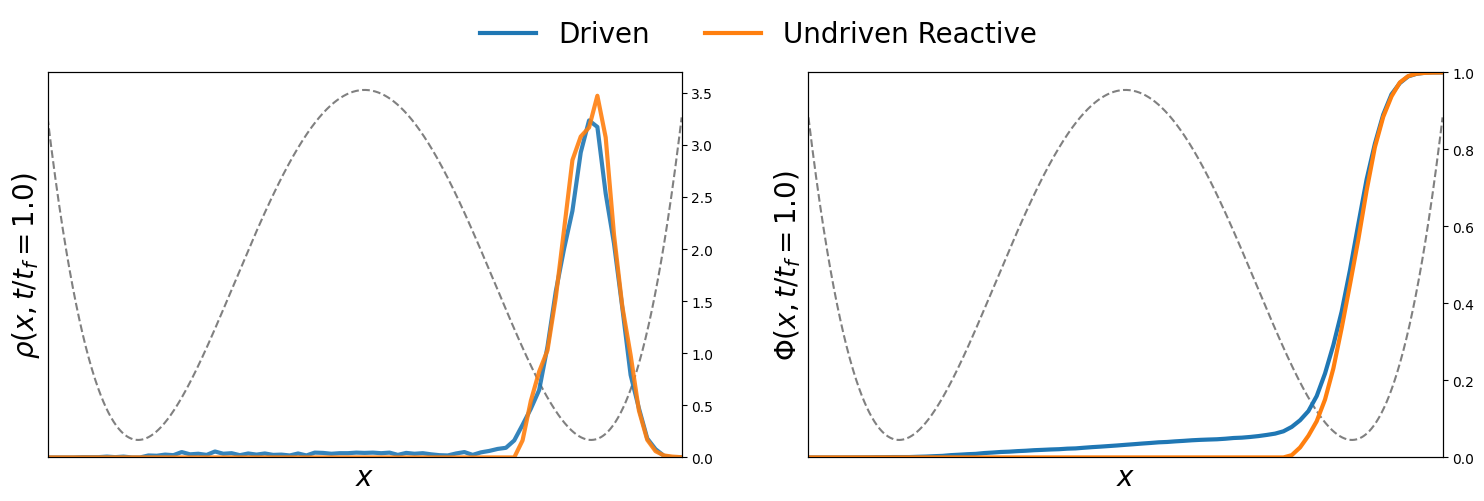

In [8]:
xst = np.linspace(-1.45,1.45,80) 
xst_= 0.5*(xst[1:] + xst[:-1])

#Compute the probability and cumulative density of values
#dat with bins xst
def getDensities(dat,xst):
    prob ,b = np.histogram(dat,xst,density=True)
    cum = np.array([np.sum(prob[:i]) for i in range(prob.shape[0])])
    cum /= cum[-1]
    return prob,cum


fig,ax = plt.subplots(1,2,figsize=(18,5))


prob_driven, cum_driven = getDensities(driven_traj[:,-1,0], xst)
prob_undriven, cum_undriven = getDensities(undriven_traj[:,-1,0], xst)

xst1 = np.linspace(-1.4,1.4,1000)
ax[0].plot(xst1,getPotential(xst1),c='gray',ls='--')

ax1 = ax[0].twinx()
l1, = ax1.plot(xst_,prob_driven,lw=3,alpha=0.9,label='Driven')
l2, = ax1.plot(xst_,prob_undriven,lw=3,alpha=0.9,label='Original Reactive')

ax2 = ax[1].twinx()
ax[1].plot(xst1,getPotential(xst1),c='gray',ls='--')
l3, = ax2.plot(xst_,cum_driven,lw=3,label='Driven')
l4, = ax2.plot(xst_,cum_undriven,lw=3,label='Undriven Reactive')

ax[0].set_xlim(-1.4,1.4)
ax[1].set_xlim(-1.4,1.4)
ax2.set_ylim(0.,1.)
ax1.set_ylim(0.,3.7)
ax[0].set_xlabel('$x$',fontsize=20)
ax[1].set_xlabel('$x$',fontsize=20)
ax[0].set_ylabel('$\\rho(x,t/t_f=1.0)$'.format(0),fontsize=20)
ax[1].set_ylabel('$\\Phi(x,t/t_f=1.0)$'.format(0),fontsize=20)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
plt.legend(fontsize=20,bbox_to_anchor=(0.4, 1.20),ncol=2,frameon=False)
driven_hBA = np.mean(hB(driven_traj[:,-1,0]))
print(driven_hBA)

### Approx. 92-93% of the driven trajectories are reactive, when computed using the indicator function $h_B = \Theta (x-0.7)$. As shown in the sensitivity analysis, the non-unity of the reactivity of the driven ensemble accounts for the total error arising from the approximation of the Doob forces as being expressed in terms of the splitting probability. This reactivity can also be increased further by increasing the observation time $t_f$.

### The trajectories that are reactive exhibit the exact statistics of the original reactive trajectory ensemble, as shown in the animation of the transient evolution of the reactive density for $t\in[0,t_f]$.

In [9]:
idx = hB(driven_traj[:,-1,0])
driven_traj = driven_traj[idx]

xst = np.linspace(-1.45,1.45,80) 
xst_= 0.5*(xst[1:] + xst[:-1])
fig,ax = plt.subplots(1,2,figsize=(18*.6,5*.65))


prob_driven, cum_driven = getDensities(driven_traj[:,0,0], xst)
prob_undriven, cum_undriven = getDensities(undriven_traj[:,0,0], xst)

xst1 = np.linspace(-1.4,1.4,1000)
ax[0].plot(xst1,getPotential(xst1),c='gray',ls='--')

ax1 = ax[0].twinx()
l1, = ax1.plot(xst_,prob_driven,lw=3,alpha=0.9)
l2, = ax1.plot(xst_,prob_undriven,lw=3,alpha=0.9)

ax2 = ax[1].twinx()
ax[1].plot(xst1,getPotential(xst1),c='gray',ls='--')
l3, = ax2.plot(xst_,cum_driven,lw=3,label='Driven Reactive, $\\langle h_{B|A} \\rangle_{\\lambda}$ =' 
                                           +'${:.3f}$'.format(driven_hBA))
l4, = ax2.plot(xst_,cum_undriven,lw=3,label='Original Reactive')

ax[0].set_xlim(-1.4,1.4)
ax[1].set_xlim(-1.4,1.4)
ax2.set_ylim(0.,1.)
ax1.set_ylim(0.,3.7)
ax[0].set_xlabel('$x$',fontsize=15)
ax[1].set_xlabel('$x$',fontsize=15)
ax[0].set_ylabel('$\\rho(x,t/t_f={:.2f})$'.format(0),fontsize=20)
ax[1].set_ylabel('$\\Phi(x,t/t_f={:.2f})$'.format(0),fontsize=20)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])

smooth = 5

plt.tight_layout(rect=(0,0,1,0.9))
plt.legend(fontsize=17,bbox_to_anchor=(-0.1, 1.25),loc='upper center',
           ncol=2,frameon=False)

plt.close()
def animate(i):
    l = i - smooth
    h = i + smooth
    prob_driven, cum_driven = getDensities(driven_traj[:,l:h,0], xst)
    prob_undriven, cum_undriven = getDensities(undriven_traj[:,l:h,0], xst)
    l1.set_data(xst_, prob_driven)
    l2.set_data(xst_, prob_undriven)

    l3.set_data(xst_, cum_driven)
    l4.set_data(xst_, cum_undriven)
    ax[0].set_ylabel('$\\rho(x,t/t_f={:.2f})$'.format(i/2000))
    ax[1].set_ylabel('$\\Phi(x,t/t_f={:.2f})$'.format(i/2000))

anim = FuncAnimation(fig, animate, range(20,2000,20),interval=30, blit=False)
HTML(anim.to_html5_video())

### The most relevant metric to measure the similarity of the two ensembles is given by the OM action/KL-divergence $\Delta U_{\lambda}$ averaged within the reactive ensembles of the driven and the original process. When the two ensembles exhibit exact statistics, the value of the OM action averaged within the the two ensembles follows:
### $\langle \Delta U_{\lambda }\rangle_{B|A,\lambda} = \ln \langle h_{B|A}\rangle_{0}/{\langle h_{B|A}\rangle_{\lambda}} = \langle \Delta U_{\lambda }\rangle_{B|A,0}$
### Another indication of the similarity of the two ensembles, closely related to the derivation of the equation above, is overlap between the probability distribution of the OM action within the two ensembles.

In [10]:
driven_eta  =  driven_traj[...,-2]
driven_lamb =  driven_traj[...,-1]

undriven_eta = undriven_traj[...,-1]
undriven_lamb= np.array([getControlForce(undriven_traj[:,i,0],(nsteps-i)*dt)
                                   for i in range(nsteps)]).T

U_driven = -np.sum(driven_lamb**2 + 2*driven_lamb*driven_eta,axis=-1)/(2*eta_sig**2)
U_undriven = np.sum(undriven_lamb**2 - 2*undriven_lamb*undriven_eta,axis=-1)/(2*eta_sig**2)

### The distributions shown below are observed to exhibit the same higher cumulants with the first cumulant shifted by a value of ~0.2. This small difference arises from a chosing finite discretization and can be lowered by chosing a smaller $dt$ as shown in the sensitivity analysis.

(-10.0, -4.0)

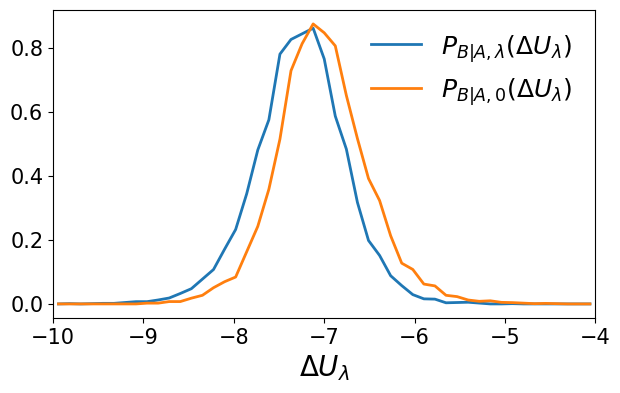

In [13]:
bns = np.linspace(-10,-4,50)
plt.figure(figsize=(7,4))
a,b = np.histogram(U_driven,bns,density=True)
plt.plot(0.5*(b[1:]+b[:-1]),a,label="$P_{B|A,\\lambda}(\Delta U_{\\lambda})$",lw=2)
a,b = np.histogram(U_undriven,bns,density=True)
plt.plot(0.5*(b[1:]+b[:-1]),a,label="$P_{B|A,0}(\Delta U_{\\lambda})$",lw=2)
plt.xlabel("$\\Delta U_{\\lambda}$",fontsize=20)
plt.tick_params(labelsize=15)
plt.legend(fontsize=18,frameon=False)
plt.xlim(-10,-4)

### Other statistics such as the last exit time $\tau$ and the transition path time $t_{\mathrm{rxn}}$ are also similar between the two ensembles, all concluding the utility of the splitting probability as the optimal controller of rare reactive events.

In [14]:
exit_driven   = dt*np.array([np.where((i[1:] > -0.7)*(i[:-1] < -0.7))[0][-1] for i in driven_traj[...,0]])/tf
exit_undriven = dt*np.array([np.where((i[1:] > -0.7)*(i[:-1] < -0.7))[0][-1] for i in undriven_traj[...,0]])/tf

enter_driven = dt*np.array([np.where((i[1:] > 0.7)*(i[:-1] < 0.7))[0][0] for i in driven_traj[...,0]])/tf
enter_undriven = dt*np.array([np.where((i[1:] > 0.7)*(i[:-1] < 0.7))[0][0] for i in undriven_traj[...,0]])/tf

tpt_driven = enter_driven-exit_driven
tpt_undriven = enter_undriven-exit_undriven


Text(0, 0.5, '$P(t_{\\mathrm{rxn}})$')

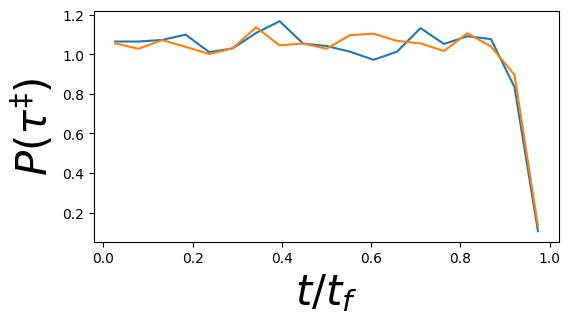

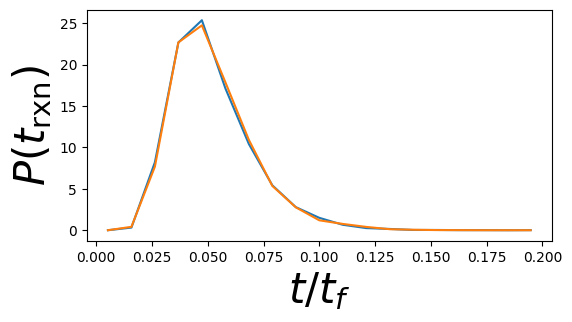

In [15]:
plt.figure(figsize=(6,3))
bins = np.linspace(0,1,20)
bins_= 0.5*(bins[1:] + bins[:-1])
prob, b = np.histogram(exit_driven,bins,density=True)
plt.plot(bins_,prob)
prob, b = np.histogram(exit_undriven,bins,density=True)
plt.plot(bins_,prob)
plt.xlabel('$t/t_f$',fontsize=30)
plt.ylabel('$P(\\tau^{\\ddag})$',fontsize=30)

plt.figure(figsize=(6,3))
bins = np.linspace(0,0.2,20)
bins_= 0.5*(bins[1:] + bins[:-1])
prob, b = np.histogram(tpt_driven,bins,density=True)
plt.plot(bins_,prob)
prob, b = np.histogram(tpt_undriven,bins,density=True)
plt.plot(bins_,prob)
plt.xlabel('$t/t_f$',fontsize=30)
plt.ylabel('$P(t_{\\mathrm{rxn}})$',fontsize=30)